In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
import numpy as np
import os
from tqdm import tqdm
import warnings


# Now, you can filter out the warnings
warnings.filterwarnings("ignore", category=FutureWarning)





/home/honglin/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def calculate_ghg_reduction(demand_data, emission_intensity_data, optimized_emission):
    # opt = np.sum((1 + np.array(optimal_solution)) * demand_data * emission_intensity_data)
    ori = np.sum(demand_data * emission_intensity_data)
    reduction = ori - np.sum(optimized_emission)
    return reduction

def calculate_ghg_reduction_percentage(demand_data, emission_intensity_data, optimized_emission):
    # opt = np.sum((1 + np.array(optimal_solution)) * demand_data * emission_intensity_data)
    ori = np.sum(demand_data * emission_intensity_data)
    reduction_percentage = (ori - np.sum(optimized_emission)) / ori
    return reduction_percentage

In [3]:
def optimize_emission_minimization(demand_data, emission_intensity_data, reg_capacity_min, reg_capacity_max, window_size, lbd, limit):
    # Assuming each month's length for a non-leap year
    # month_lengths = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    # quarter_lengths = [90, 91, 92, 92]
    # month_hours = [days * 24 for days in month_lengths]
    # quarter_hours = [days * 24 for days in quarter_lengths]
    # year_hours = [8760]

    # Results storage
    optimized_emission = []
    load_changes = []
    regulation_hours = []

    lambda_value = lbd  # Adjust based on preference for minimizing load change duration
    M = 100  # Big M, might need adjustment based on the problem's specifics
    # tolerance = 1e-4  # Small tolerance for considering x_i as nonzero

    start_index = 0
    for month, hours in enumerate(window_size):
        # Define the optimization model for the month
        m = Model(f'Month_{month+1}')
        m.Params.Threads = 128
        m.setParam('OutputFlag', 0)

        # Decision variables
        x = m.addVars(hours, lb=-limit, ub=limit, name="x")
        z = m.addVars(hours, vtype=GRB.BINARY, name="z")
        E = m.addVars(hours, name="E")

        # Update model to integrate new variables
        m.update()
        total_demand = np.sum(demand_data[start_index:start_index+hours])


        # Objective function
        m.setObjective(quicksum(E[i] for i in range(hours)) + lambda_value * quicksum(z[i] for i in range(hours)), GRB.MINIMIZE)

        # Constraints
        for i in range(hours):
            m.addConstr(E[i] == (1 + x[i]) * demand_data[i+start_index] * emission_intensity_data[i+start_index], name=f"E_{i}")
            m.addConstr(x[i] * demand_data[i+start_index] <= reg_capacity_max[i+start_index], "GenCapMax")
            m.addConstr((1 + x[i]) * demand_data[i+start_index] >= reg_capacity_min[i+start_index], "GenCapMin")
            # z >= (x/M) and z >= (-x/M) ensure z is 1 when x is non-zero
            m.addConstr(z[i] >= x[i]/M, "positive_constraint")
            m.addConstr(z[i] >= -x[i]/M, "negative_constraint")

            # x <= M*z and x >= -M*z ensure x is 0 when z is 0
            m.addConstr(x[i] <= M*z[i], "upper_bound")
            m.addConstr(x[i] >= -M*z[i], "lower_bound")

        m.addConstr(quicksum((1 + x[i]) * demand_data[i+start_index] for i in range(hours)) >= total_demand, "TotalDemand")

        # Solve the model
        m.optimize()


        if model.status == GRB.OPTIMAL:
            optimized_emission.extend([E[i].X for i in range(hours)])
            load_changes.extend([x[i].X for i in range(hours)])
            regulation_hours.extend([z[i].X for i in range(hours)])
        else:
            print("Optimization failed")

        start_index += hours

    amount = calculate_ghg_reduction(demand_data, emission_intensity_data, optimized_emission)
    percentage = calculate_ghg_reduction_percentage(demand_data, emission_intensity_data, optimized_emission)
    
    return optimized_emission, load_changes, regulation_hours, amount, percentage

        

In [ ]:
x = m.addVars(hours, lb=-limit, ub=limit, name="x")
        z = m.addVars(hours, vtype=GRB.BINARY, name="z")
        E = m.addVars(hours, name="E")

        # Update model to integrate new variables
        m.update()
        total_demand = np.sum(demand_data[start_index:start_index+hours])


        # Objective function
        m.setObjective(quicksum(E[i] for i in range(hours)) + lambda_value * quicksum(z[i] for i in range(hours)), GRB.MINIMIZE)

        # Constraints
        for i in range(hours):
            m.addConstr(E[i] == (1 + x[i]) * demand_data[i+start_index] * emission_intensity_data[i+start_index], name=f"E_{i}")
            m.addConstr(x[i] * demand_data[i+start_index] <= reg_capacity_max[i+start_index], "GenCapMax")
            m.addConstr((1 + x[i]) * demand_data[i+start_index] >= reg_capacity_min[i+start_index], "GenCapMin")
            # z >= (x/M) and z >= (-x/M) ensure z is 1 when x is non-zero
            m.addConstr(z[i] >= x[i]/M, "positive_constraint")
            m.addConstr(z[i] >= -x[i]/M, "negative_constraint")

            # x <= M*z and x >= -M*z ensure x is 0 when z is 0c
            m.addConstr(x[i] <= M*z[i], "upper_bound")
            m.addConstr(x[i] >= -M*z[i], "lower_bound")

        m.addConstr(quicksum((1 + x[i]) * demand_data[i+start_index] for i in range(hours)) >= total_demand, "TotalDemand")

        # Solve the model
        m.optimize()


In [ ]:
# Directory containing the CSV files
directory = './Output/'

# Initialize a dictionary to hold the dataframes for each region
region_data = {}
region_results = {}
curtail_rate = 0.1

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)

        # Convert 'Local time' to datetime and extract year and quarter
        df['Local time'] = pd.to_datetime(df['Local time'])
        df['Year'] = df['Local time'].dt.year
        df = df[df['Year'] == 2023]
        df['Quarter'] = df['Local time'].dt.quarter
        df['CO2 Emissions Intensity for Generated Electricity'].interpolate(inplace=True)
        df['Consumed Electricity'].interpolate(inplace=True)
        # Sum up the renewable and non-renewable generation
        df['Renewable'] = df[['NG: SUN', 'NG: WND', 'NG: WAT']].sum(axis=1)
        # df['NonRenewable'] = df[df.columns.difference(['Local time', 'Year', 'Quarter', 'Renewable'])].sum(axis=1)
        df['NonRegulation'] = df[['NG: COL','NG: NUC']].sum(axis=1)


        region = filename.replace('.csv', '')
        region_data[region] = df
        

# Analysis and Plotting
for region, df in tqdm(region_data.items(), desc='Outer loop'):
    # print(f'{region}')
    df['CO2 Emissions Intensity for Generated Electricity'].interpolate(inplace=True)
    df['Consumed Electricity'].interpolate(inplace=True)
    emission_intensity_data = df["CO2 Emissions Intensity for Generated Electricity"].values
    demand_data = df["Consumed Electricity"].values
    reg_capacity_min = df["NonRegulation"].values
    reg_capacity_max = curtail_rate * df["Renewable"].values
    # for i in tqdm(range(100), desc='Progress'):
    for window in ['month', 'quarter', 'year']:
        if window == 'month':
            window_size = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]
        elif window == 'quarter':
            window_size = [2160, 2208, 2208, 2184]
        else:
            window_size = [8760]
        for lbd in [0, 10, 30, 50, 100]:
            for limit in [round(i, 2) for i in np.arange(0.01, 0.11, 0.01)]:
                results = optimize_emission_minimization(demand_data, emission_intensity_data, reg_capacity_min, reg_capacity_max, window_size, lbd, limit)
          
                df_results = pd.DataFrame({'Optimized Emission': results[0],
                                        'Load Changes': results[1],
                                        'Regulation Hours': results[2],
                                        'Amount': results[3],
                                        'Percentage': results[4]})
                
                # Save the dataframe as a CSV
                df_results.to_csv(f'./results/{region}_{window}_{lbd}_{limit}.csv', index=False)



In [ ]:
region_results = {}
# 
for i in ['CAL', 'NW', 'TEX', 'CAR', 'MIDA', 'FLA', 'SW', 'CENT', 'MIDW', 'TEN', 'SE', 'NE', 'NY']: # 
    df_year = pd.read_csv(f'./case1_lbd0_0.05limit/{i}_year.csv')
    df_quarter = pd.read_csv(f'./case1_lbd0_0.05limit/{i}_quarter.csv')
    df_month = pd.read_csv(f'./case1_lbd0_0.05limit/{i}_month.csv')
    df = pd.read_csv(f'./Output/{i}.csv')
    df['Local time'] = pd.to_datetime(df['Local time'])
    df['Year'] = df['Local time'].dt.year
    df = df[df['Year'] == 2023]
    df['CO2 Emissions Intensity for Generated Electricity'].interpolate(inplace=True)
    df['Consumed Electricity'].interpolate(inplace=True)

    new_df = pd.DataFrame({'time': df['Local time'].values,
                                'load': df['Consumed Electricity'].values,
                                'intensity': df['CO2 Emissions Intensity for Generated Electricity'].values,
                                'r_month': df_month['Load Changes'].values,
                                'r_quarter': df_quarter['Load Changes'].values,
                                'r_year': df_year['Load Changes'].values})
    

    region_results[i] = new_df

for region, df in region_results.items():
    df['time'] = pd.to_datetime(df['time'])
    df['month'] = df['time'].dt.month
    df['quarter'] = df['time'].dt.quarter
    df['d_month'] = df['load'] * df['intensity'] * df['r_month']
    df['d_quarter'] = df['load'] * df['intensity'] * df['r_quarter']
    df['d_year'] = df['load'] * df['intensity'] * df['r_year']
    # quarterly_ded = df.groupby('quarter')['d_quarter'].sum()
    monthly_ded = df.groupby('month')['d_month'].sum()
    # print(f'{region} quarterly reduction: {quarterly_ded}')
    print(f'{region} monthly reduction: {monthly_ded}')

In [2]:
ny_demand = pd.read_json('./Output/demand_2023_localtime.json')
ny_demand['period'] = pd.to_datetime(ny_demand['period'], utc=True)
ny_demand['quarter'] = ny_demand['period'].dt.quarter
ny_demand['month'] = ny_demand['period'].dt.month


df = pd.read_csv('./Output/NY.csv')
df['Local time'] = pd.to_datetime(df['Local time'])
df['Year'] = df['Local time'].dt.year
df = df[df['Year'] == 2023]

df['CO2 Emissions Intensity for Generated Electricity'].interpolate(inplace=True)


region_data={}
region_data['zonj'] = ny_demand[ny_demand['subba'] == 'ZONJ']
region_data['zoni'] = ny_demand[ny_demand['subba'] == 'ZONI']
region_data['zonk'] = ny_demand[ny_demand['subba'] == 'ZONK']
region_data['zone'] = ny_demand[ny_demand['subba'] == 'ZONE']
region_data['zond'] = ny_demand[ny_demand['subba'] == 'ZOND']
region_data['zonf'] = ny_demand[ny_demand['subba'] == 'ZONF']


emission_intensity_data = df["CO2 Emissions Intensity for Generated Electricity"].values
# Analysis and Plotting
for region, df in region_data.items():
    df.set_index('period', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    date_range = pd.date_range(start='2023-01-01 00:00:00+00:00', end='2023-12-31 23:00:00+00:000', freq='H')
    df = df.reindex(date_range)
    df['value'].interpolate(inplace=True)
    demand_data = df["value"].values


    for window in ['month', 'quarter', 'year']:
        if window == 'month':
            window_size = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]
        elif window == 'quarter':
            window_size = [2160, 2208, 2208, 2184]
        else:
            window_size = [8760]
        for lbd in [0, 10, 100]:
            for limit in [0.01, 0.03, 0.05, 0.1]:
                results = optimize_emission_minimization(demand_data, emission_intensity_data, window_size, lbd, limit)
          
                df_results = pd.DataFrame({'Optimized Emission': results[0],
                                        'Load Changes': results[1],
                                        'Regulation Hours': results[2],
                                        'Amount': results[3],
                                        'Percentage': results[4]})
                
                # Save the dataframe as a CSV
                df_results.to_csv(f'./results/{region}_{window}_{lbd}_{limit}.csv', index=False)


/tmp/ipykernel_3241138/3851684667.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ny_demand['period'] = pd.to_datetime(ny_demand['period'], utc=True)


NameError: name 'optimize_emission_minimization' is not defined

In [9]:
import pandas as pd
import os

# Define the directory containing the results folders
base_dir = './results/newc3/'

# Placeholder for aggregated data


# Iterate through each folder in the base directory
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        aggregated_data = []
        # Iterate through each file in the folder
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file.endswith('.csv'):
                # Extract metadata from file name
                region_name, window_size, lambda_val, limit = file.replace('.csv', '').split('_')
                # Read the CSV file
                df = pd.read_csv(file_path)
                # Aggregate the required information
                regulation_hours_sum = df['Regulation Hours'].sum()
                first_amount = df['Amount'].iloc[0]
                first_percentage = df['Percentage'].iloc[0]
                # Append the aggregated information to the list
                aggregated_data.append([region_name, lambda_val, first_amount, first_percentage, regulation_hours_sum])

        # Convert the aggregated data to a DataFrame
        result_df = pd.DataFrame(aggregated_data, columns=['Region Name','lambda', 'Amount', 'Percentage', 'Regulation Hours'])

        # Save the DataFrame to a new CSV file
        result_df.to_csv(f'{folder_path}/aggregated_results.csv', index=False)


In [143]:
results = {}
for i in ['rural', 'urban']:
    df = pd.read_csv(f'./results/case3/{i}/aggregated_results.csv')
    df['Amount'] = df['Amount'] / 1000
    df['Percentage'] = df['Percentage'] * 100

    # df_filtered = df[df['Region Name'] != 'NY']

    df_pivoted = df.pivot(index='Region Name', columns='lambda', values='Percentage')

    # index_order = [
    #     'CAL', 'NW', 'TEX', 'CAR', 'MIDA', 'FLA', 
    #     'SW', 'CENT', 'MIDW', 'TEN', 'SE', 'NE'
    # ]

    index_order = [
        'zonj', 'zoni', 'zonk', 'zone', 'zonc', 'zonf'
    ]

    index_order = [index for index in index_order if index in df_pivoted.index]
    df_reordered = df_pivoted.reindex(index_order)
    results[i] = df_reordered

concatenated_df = pd.DataFrame()

# Iterate through the results dictionary and add an energy type column
for energy_type, df in results.items():
    # Add a new column to indicate the energy type
    df['Energy Type'] = energy_type  # This line adds the column
    
    # Concatenate this DataFrame with the accumulated one
    concatenated_df = pd.concat([concatenated_df, df])

# Reset the index if you want 'Region Name' as a regular column
concatenated_df.reset_index(inplace=True)


concatenated_df.to_csv('./results/case3/summary_rate.csv', index=False)


In [97]:
import pandas as pd

# Load the aggregated results
aggregated_results_path = './aggregated_results.csv'  # Replace with your file path
aggregated_df = pd.read_csv(aggregated_results_path)

# Create a new column that combines window size, lambda, and limit into the desired format
aggregated_df['Category'] = aggregated_df['Window Size'] + '_' + aggregated_df['Lambda'].astype(str) + '_' + aggregated_df['Limit'].astype(str)

# Aggregate data by Region Name and Category if there are duplicates
aggregated_df = aggregated_df.groupby(['Region Name', 'Category']).agg({
    'Amount': 'first',  # Assuming you want the first value of Amount
    'Percentage': 'first',  # Assuming you want the first value of Percentage
    'Regulation Hours': 'first'  # Summing the Regulation Hours
}).reset_index()

# Pivot the DataFrame to get the desired shape
pivot_df = (aggregated_df.set_index(['Region Name', 'Category'])
            .unstack('Category')
            .reset_index())

# Flatten the MultiIndex columns, handling possible tuples
pivot_df.columns = [' '.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in pivot_df.columns.values]

# Save the pivoted DataFrame to a new CSV file
pivot_df.to_csv('categorized_results.csv', index=False)


In [43]:
# Directory containing the CSV files
directory = './Output/'

# Initialize a dictionary to hold the dataframes for each region
region_data = {}
region_results = {}
curtail_rate = 0.1

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        region = filename.replace('.csv', '')
        if region in ['SW', 'CENT', 'MIDW', 'NE',  'TEN', 'SE']:
        # Read the CSV file
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)

            # Convert 'Local time' to datetime and extract year and quarter
            df['Local time'] = pd.to_datetime(df['Local time'])
            df['Year'] = df['Local time'].dt.year
            df = df[df['Year'] == 2023]
            df['Quarter'] = df['Local time'].dt.quarter
            df['CO2 Emissions Intensity for Generated Electricity'].interpolate(inplace=True)
            df['Consumed Electricity'].interpolate(inplace=True)
            # Sum up the renewable and non-renewable generation
            df['Renewable'] = df[['NG: SUN', 'NG: WND', 'NG: WAT']].sum(axis=1)
            # df['NonRenewable'] = df[df.columns.difference(['Local time', 'Year', 'Quarter', 'Renewable'])].sum(axis=1)
            df['NonRegulation'] = df[['NG: COL','NG: NUC']].sum(axis=1)
            

            region_data[region] = df
        

# Analysis and Plotting
for region, df in region_data.items():
    # print(f'{region}')
    df['CO2 Emissions Intensity for Generated Electricity'].interpolate(inplace=True)
    df['Consumed Electricity'].interpolate(inplace=True)
    emission_intensity_data = df["CO2 Emissions Intensity for Generated Electricity"].values
    demand_data = df["Consumed Electricity"].values
    reg_capacity_min = df["NonRegulation"].values
    reg_capacity_max = curtail_rate * df["Renewable"].values
    
    window_size = [2160, 2208, 2208, 2184]
    lbd = 10
    for limit in [round(i, 2) for i in np.arange(0.01, 0.31, 0.01)]:
        results = optimize_emission_minimization(demand_data, emission_intensity_data, reg_capacity_min, reg_capacity_max, window_size, lbd, limit)
    
        df_results = pd.DataFrame({'Optimized Emission': results[0],
                                'Load Changes': results[1],
                                'Regulation Hours': results[2],
                                'Amount': results[3],
                                'Percentage': results[4]})
        
        # Save the dataframe as a CSV
        df_results.to_csv(f'./results/{region}_quarter_10_{limit}.csv', index=False)


In [30]:
import pandas as pd
import os

# Define the directory containing the results folders
base_dir = './sa/consumed/'

# Placeholder for aggregated data
aggregated_data = []

# Iterate through each folder in the base directory

for file in os.listdir(base_dir):
    file_path = os.path.join(base_dir, file)
    if file.endswith('.csv'):
        # Extract metadata from file name
        region_name, value = file.replace('.csv', '').split('_')
        # Read the CSV file
        df = pd.read_csv(file_path)
        # Aggregate the required information
        regulation_hours_sum = df['Regulation Hours'].sum()
        first_amount = df['Amount'].iloc[0]
        first_percentage = df['Percentage'].iloc[0]
        # Append the aggregated information to the list
        aggregated_data.append([region_name, value, first_amount, first_percentage, regulation_hours_sum])

# Convert the aggregated data to a DataFrame
result_df = pd.DataFrame(aggregated_data, columns=['Region Name', 'value', 'Amount', 'Percentage', 'Regulation Hours'])

# Save the DataFrame to a new CSV file
result_df.to_csv('aggregated_results_sa_consumed.csv', index=False)


/tmp/ipykernel_2452727/912505654.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ny_demand['period'] = pd.to_datetime(ny_demand['period'], utc=True)


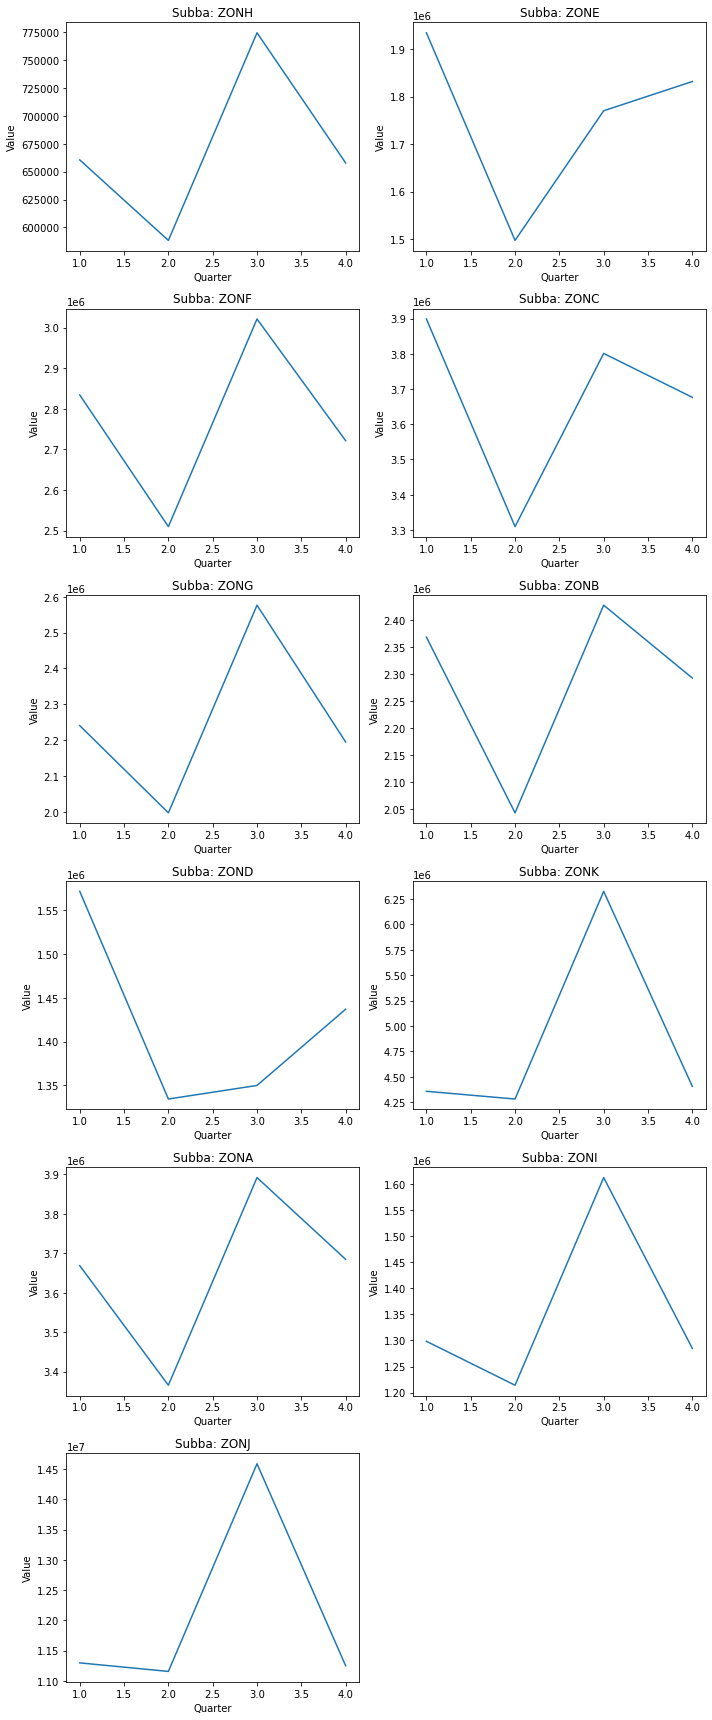

In [107]:
import matplotlib.pyplot as plt

ny_demand = pd.read_json('./Output/demand_2023_localtime.json')
ny_demand['period'] = pd.to_datetime(ny_demand['period'], utc=True)
ny_demand['quarter'] = ny_demand['period'].dt.quarter
ny_demand['month'] = ny_demand['period'].dt.month
quarterly_demand = ny_demand.groupby(['subba', 'quarter'])['value'].sum()#.unstack('subba')

# Plotting
# quarterly_demand.plot(kind='line')
# plt.xlabel('Quarter')
# plt.ylabel('Value')
# plt.title('Value by Subba and Quarter')
# plt.legend(title='Subba')
# plt.grid(True)
# plt.show()
# quarterly_demand.loc['ZONJ'].plot(kind='line')

# Get unique subba values for iteration
subbas = ny_demand['subba'].unique()

# Determine the layout of the subplots
n_subbas = len(subbas)
n_cols = 2  # For example, 2 columns of subplots
n_rows = n_subbas // n_cols + (n_subbas % n_cols > 0)

plt.figure(figsize=(10, n_rows * 4))  # Adjust figure size as needed

for i, subba in enumerate(subbas, start=1):
    plt.subplot(n_rows, n_cols, i)
    # Select data for current subba and unstack quarters for plotting
    data_for_subba = quarterly_demand.loc[subba]#.unstack('subba')
    data_for_subba.plot(kind='line', legend=False)
    plt.title(f'Subba: {subba}')
    plt.xlabel('Quarter')
    plt.ylabel('Value')
    plt.tight_layout()

plt.show()

In [23]:
# Assigning the given numbers to a dictionary with keys ranging from 'zona' to 'zonk'
keys = ['zona', 'zonb', 'zonc', 'zond', 'zone', 'zonf', 'zong', 'zonh', 'zoni', 'zonj', 'zonk']
values = [
    1.646207634,
    0.886385399,
    1.367074195,
    0.127132336,
    0.886413564,
    1.174616921,
    1.38405745,
    0.210277537,
    0.809413926,
    8.335897,
    2.781249514
]

epp = [8.916029602,
10.84602027,
11.23575008,
46.24942942,
8.293224853,
10.16066327,
6.735002945,
13.77794814,
7.126384674,
5.966558848,
7.228677578
]

demand = [
    14.677636,
9.613754,
15.360104,
5.879798,
7.351227,
11.934887,
9.321631,
2.897193,
5.768195,
49.73662,
20.104756
]

# Creating the dictionary
zon_pop = dict(zip(keys, values))
zon_epp = dict(zip(keys, epp))
zon_demand = dict(zip(keys, demand))
# zon_pop


In [40]:
# case 3 subregions in NY lambda sensitivity test

def ny_optimize_emission_minimization(demand_data, emission_intensity_data, window_size, lbd, limit):


    # Results storage
    optimized_emission = []
    load_changes = []
    regulation_hours = []

    lambda_value = lbd  # Adjust based on preference for minimizing load change duration
    M = 100  # Big M, might need adjustment based on the problem's specifics
    # tolerance = 1e-4  # Small tolerance for considering x_i as nonzero

    start_index = 0
    for month, hours in enumerate(window_size):
        # Define the optimization model for the month
        m = Model(f'Month_{month+1}')
        # m.Params.Threads = 128
        m.setParam('OutputFlag', 0)

        # Decision variables
        x = m.addVars(hours, lb=-limit, ub=limit, name="x")
        z = m.addVars(hours, vtype=GRB.BINARY, name="z")
        E = m.addVars(hours, name="E")

        # Update model to integrate new variables
        m.update()
        total_demand = np.sum(demand_data[start_index:start_index+hours])


        # Objective function
        m.setObjective(quicksum(E[i] for i in range(hours)) + lambda_value * quicksum(z[i] for i in range(hours)), GRB.MINIMIZE)

        # Constraints
        for i in range(hours):
            m.addConstr(E[i] == (1 + x[i]) * demand_data[i+start_index] * emission_intensity_data[i+start_index], name=f"E_{i}")
            # m.addConstr(x[i] * demand_data[i+start_index] <= reg_capacity_max[i+start_index], "GenCapMax")
            # m.addConstr((1 + x[i]) * demand_data[i+start_index] >= reg_capacity_min[i+start_index], "GenCapMin")
            # z >= (x/M) and z >= (-x/M) ensure z is 1 when x is non-zero
            m.addConstr(z[i] >= x[i]/M, "positive_constraint")
            m.addConstr(z[i] >= -x[i]/M, "negative_constraint")

            # x <= M*z and x >= -M*z ensure x is 0 when z is 0
            m.addConstr(x[i] <= M*z[i], "upper_bound")
            m.addConstr(x[i] >= -M*z[i], "lower_bound")

        m.addConstr(quicksum((1 + x[i]) * demand_data[i+start_index] for i in range(hours)) >= total_demand, "TotalDemand")

        # Solve the model
        m.optimize()

        # Store results
        optimized_emission.extend([E[i].X for i in range(hours)])
        load_changes.extend([x[i].X for i in range(hours)])
        regulation_hours.extend([z[i].X for i in range(hours)])

        start_index += hours

        

    amount = calculate_ghg_reduction(demand_data, emission_intensity_data, optimized_emission)
    percentage = calculate_ghg_reduction_percentage(demand_data, emission_intensity_data, optimized_emission)

    return optimized_emission, load_changes, regulation_hours, amount, percentage



ny_demand = pd.read_json('./Output/demand_2023_localtime.json')
ny_demand['period'] = pd.to_datetime(ny_demand['period'], utc=True)
ny_demand['quarter'] = ny_demand['period'].dt.quarter
ny_demand['month'] = ny_demand['period'].dt.month


df = pd.read_csv('./Output/NY.csv')
df['Local time'] = pd.to_datetime(df['Local time'])
df['Year'] = df['Local time'].dt.year
df = df[df['Year'] == 2023]

df['CO2 Emissions Intensity for Generated Electricity'].interpolate(inplace=True)


region_data={}
region_data['zonj'] = ny_demand[ny_demand['subba'] == 'ZONJ']
region_data['zoni'] = ny_demand[ny_demand['subba'] == 'ZONI']
region_data['zonk'] = ny_demand[ny_demand['subba'] == 'ZONK']
region_data['zone'] = ny_demand[ny_demand['subba'] == 'ZONE']
region_data['zonc'] = ny_demand[ny_demand['subba'] == 'ZONC']
region_data['zonf'] = ny_demand[ny_demand['subba'] == 'ZONF']




emission_intensity_data = df["CO2 Emissions Intensity for Generated Electricity"].values
# Analysis and Plotting
for region, df in tqdm(region_data.items(), desc='Outer loop'):
    df.set_index('period', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    date_range = pd.date_range(start='2023-01-01 00:00:00+00:00', end='2023-12-31 23:00:00+00:000', freq='H')
    df = df.reindex(date_range)
    df['value'].interpolate(inplace=True)
    demand_data = df["value"].values


    # for window in ['month', 'quarter', 'year']:
    #     if window == 'month':
    #         window_size = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]
    #     elif window == 'quarter':
    #         window_size = [2160, 2208, 2208, 2184]
    #     else:
    #         window_size = [8760]
    #     for lbd in [i for i in np.arange(0, 11, 2)]:
    #         for limit in [round(i, 2) for i in np.arange(0.01, 0.11, 0.02)]:
    #             results = ny_optimize_emission_minimization(demand_data, emission_intensity_data, window_size, lbd, limit)
          
    #             df_results = pd.DataFrame({'Optimized Emission': results[0],
    #                                     'Load Changes': results[1],
    #                                     'Regulation Hours': results[2],
    #                                     'Amount': results[3],
    #                                     'Percentage': results[4]})
                
    #             # Save the dataframe as a CSV
    #             df_results.to_csv(f'./results/{region}_{window}_{lbd}_{limit}.csv', index=False)


    for i in [round(i, 2) for i in np.arange(0.2, 1.3, 0.2)]:
        
        window_size = [2160, 2208, 2208, 2184]
        lbd = i*zon_demand[region]#zon_pop[region]*zon_epp[region]
        limit = 0.05

        results = ny_optimize_emission_minimization(demand_data, emission_intensity_data, window_size, lbd, limit)

        df_results = pd.DataFrame({'Optimized Emission': results[0],
                                'Load Changes': results[1],
                                'Regulation Hours': results[2],
                                'Amount': results[3],
                                'Percentage': results[4]})

        # Save the dataframe as a CSV
        df_results.to_csv(f'./results/{region}_quarter_{i}_0.05.csv', index=False)



/tmp/ipykernel_3241138/1043679842.py:70: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ny_demand['period'] = pd.to_datetime(ny_demand['period'], utc=True)
Outer loop: 100%|██████████| 6/6 [00:27<00:00,  4.63s/it]


In [1]:
import pandas as pd
ny_demand = pd.read_json('./Output/demand_2023_localtime.json')
ny_demand

/home/honglin/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


,period,subba,subba-name,parent,parent-name,value,value-units
0,2022-12-31T19-05,ZONH,Millwood,NYIS,New York Independent System Operator,314,megawatthours
1,2022-12-31T19-05,ZONE,Mohawk Valley,NYIS,New York Independent System Operator,877,megawatthours
2,2022-12-31T19-05,ZONF,Capital,NYIS,New York Independent System Operator,1407,megawatthours
3,2022-12-31T19-05,ZONC,Central,NYIS,New York Independent System Operator,1762,megawatthours
4,2022-12-31T19-05,ZONG,Hudson Valley,NYIS,New York Independent System Operator,1198,megawatthours
...,...,...,...,...,...,...,...
96355,2023-12-31T18-05,ZONG,Hudson Valley,NYIS,New York Independent System Operator,1266,megawatthours
96356,2023-12-31T18-05,ZONJ,New York City,NYIS,New York Independent System Operator,5582,megawatthours
96357,2023-12-31T18-05,ZOND,North,NYIS,New York Independent System Operator,746,megawatthours
96358,2023-12-31T18-05,ZONH,Millwood,NYIS,New York Independent System Operator,383,megawatthours


In [42]:
import pandas as pd
import numpy as np
import glob
import os

# Define the start and end of 2023
start_date = '2023-01-01'
end_date = '2024-1-1'

# Create a DateTimeIndex for each day in 2023
date_range = pd.date_range(start=start_date, end=end_date)

# Initialize the final DataFrame with dates as the index
final_df = pd.DataFrame(index=date_range)

# Define the file selection criteria
regions = ['zonj', 'zoni', 'zonk', 'zone', 'zonc', 'zonf']
window_size = 'quarter'
limit = '0.05'
results_folder = './results'

for lbd in [round(i, 2) for i in np.arange(0.2, 1.3, 0.2)]: 
        file_pattern = f"{results_folder}/*_{window_size}_{lbd}_{limit}.csv"
        all_files = glob.glob(file_pattern)
        # Process each file
        for file_path in all_files:
            region_name = os.path.basename(file_path).split('_')[0]
            if region_name in regions:
                # print(f"Processing {file_path} for {region_name}")
                df = pd.read_csv(file_path)
                
                # Assuming each row corresponds to an hour, generate hourly timestamps for 2023
                hourly_index = pd.date_range(start=start_date, end=end_date, freq='H')[:len(df)]
                
                # Sum the Regulation Hours per day
                df['Date'] = hourly_index.date
                daily_sums = df.groupby('Date')['Regulation Hours'].sum()
                
                # Add the daily sums to the final DataFrame
                final_df[f'{region_name}_{lbd}'] = daily_sums

# Fill missing values with 0, assuming days without data have 0 Regulation Hours
final_df.fillna(0, inplace=True)

# Reset index to include the date as a column for CSV export
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'Date'}, inplace=True)

# Save the final DataFrame as a CSV file
output_file_path = 'summed_regulation_hours_sa.csv'
final_df.to_csv(output_file_path, index=False)

# print(f"Summed Regulation Hours per day for 2023 saved to {output_file_path}")


In [45]:
df = pd.read_csv('./summed_regulation_hours_sa.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
# df = df[df['Year'] == 2023]
# df['Month'] = df['Date'].dt.month
df.set_index('Date', inplace=True)


monthly_sums = df.resample('M').sum()[['zonj_0.6', 'zoni_0.6', 'zonk_0.6', 'zone_0.6', 'zonc_0.6', 'zonf_0.6']]
monthly_sums

,zonj_0.6,zoni_0.6,zonk_0.6,zone_0.6,zonc_0.6,zonf_0.6
Date,,,,,,
2023-01-31,9.0,8.0,7.0,16.0,11.0,11.0
2023-02-28,30.0,33.0,29.0,67.0,56.0,43.0
2023-03-31,24.0,26.0,23.0,57.0,50.0,35.0
2023-04-30,17.0,9.0,16.0,13.0,17.0,17.0
2023-05-31,130.0,120.0,126.0,86.0,111.0,100.0
2023-06-30,107.0,90.0,90.0,80.0,99.0,80.0
2023-07-31,76.0,60.0,108.0,36.0,42.0,44.0
2023-08-31,56.0,40.0,94.0,18.0,17.0,18.0
2023-09-30,257.0,246.0,274.0,183.0,199.0,217.0


In [35]:
import os
import pandas as pd

# Path to the directory containing CSV files
dir_path = "./Output"

# List all CSV files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# Columns of interest
columns_of_interest = ['NG: SUN', 'NG: WND', 'NG: WAT', 'NG: COL', 'NG: NUC', 'CO2 Emissions Intensity for Generated Electricity', 'Consumed Electricity']

# Process each CSV file
for file_name in csv_files:
    file_path = os.path.join(dir_path, file_name)
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure all columns of interest are in the dataframe
    if all(column in df.columns for column in columns_of_interest):
        # Replace missing values with 0
        df[columns_of_interest] = df[columns_of_interest].fillna(0)
        
        # Replace values less than 0 with 0
        df[columns_of_interest] = df[columns_of_interest].clip(lower=0)
        
        # Special handling for 'Consumed Electricity'
        for i in range(1, len(df) - 1):
            if df.loc[i, 'Consumed Electricity'] == 0:
                prev_val = df.loc[i - 1, 'Consumed Electricity']
                next_val = df.loc[i + 1, 'Consumed Electricity']
                df.loc[i, 'Consumed Electricity'] = (prev_val + next_val) / 2
                
        # Save the modified dataframe back to CSV
        df.to_csv(file_path, index=False)

# Operation completed
"CSV files have been processed and updated."


'CSV files have been processed and updated.'

In [19]:
def calculate_ghg_reduction(demand_data, current_intensity, optimized_emission):
    # opt = np.sum((1 + np.array(optimal_solution)) * demand_data * emission_intensity_data)
    ori = np.sum(demand_data * current_intensity)
    reduction = ori - np.sum(optimized_emission)
    return reduction

def calculate_ghg_reduction_percentage(demand_data, current_intensity, optimized_emission):
    # opt = np.sum((1 + np.array(optimal_solution)) * demand_data * emission_intensity_data)
    ori = np.sum(demand_data * current_intensity)
    reduction_percentage = (ori - np.sum(optimized_emission)) / ori
    return reduction_percentage



def sa_optimize_emission_minimization(demand_data, emission_intensity_data, current_intensity, reg_capacity_min, reg_capacity_max, window_size, lbd, limit):

    # Results storage
    optimized_emission = []
    load_changes = []
    regulation_hours = []

    lambda_value = lbd  # Adjust based on preference for minimizing load change duration
    M = 100  # Big M, might need adjustment based on the problem's specifics
    # tolerance = 1e-4  # Small tolerance for considering x_i as nonzero

    start_index = 0
    for window, hours in enumerate(window_size):
        # Define the optimization model for the window
        m = Model(f'window{window+1}')
        # m.Params.Threads = 128
        m.setParam('OutputFlag', 0)

        # Decision variables
        x = m.addVars(hours, lb=-limit, ub=limit, name="x")
        z = m.addVars(hours, vtype=GRB.BINARY, name="z")
        E = m.addVars(hours, name="E")

        # Update model to integrate new variables
        m.update()
        total_demand = np.sum(demand_data[start_index:start_index+hours])


        # Objective function
        m.setObjective(quicksum(E[i] for i in range(hours)) + lambda_value * quicksum(z[i] for i in range(hours)), GRB.MINIMIZE)

        # Constraints
        for i in range(hours):
            m.addConstr(E[i] == (1 + x[i]) * demand_data[i+start_index] * emission_intensity_data[i+start_index], name=f"E_{i}")
            m.addConstr(x[i] * demand_data[i+start_index] <= reg_capacity_max[i+start_index], "GenCapMax")
            m.addConstr((1 + x[i]) * demand_data[i+start_index] >= reg_capacity_min[i+start_index], "GenCapMin")
            # z >= (x/M) and z >= (-x/M) ensure z is 1 when x is non-zero
            m.addConstr(z[i] >= x[i]/M, "positive_constraint")
            m.addConstr(z[i] >= -x[i]/M, "negative_constraint")

            # x <= M*z and x >= -M*z ensure x is 0 when z is 0
            m.addConstr(x[i] <= M*z[i], "upper_bound")
            m.addConstr(x[i] >= -M*z[i], "lower_bound")

        m.addConstr(quicksum((1 + x[i]) * demand_data[i+start_index] for i in range(hours)) >= total_demand, "TotalDemand")

        # Solve the model
        m.optimize()


        if m.status == GRB.OPTIMAL:
            optimized_emission.extend([E[i].X for i in range(hours)])
            load_changes.extend([x[i].X for i in range(hours)])
            regulation_hours.extend([z[i].X for i in range(hours)])
        else:
            print("Optimization failed")

        start_index += hours

    amount = calculate_ghg_reduction(demand_data, current_intensity, optimized_emission)
    percentage = calculate_ghg_reduction_percentage(demand_data, current_intensity, optimized_emission)
    
    return optimized_emission, load_changes, regulation_hours, amount, percentage




In [26]:
# Sensitivity Analysis

# Directory containing the CSV files
directory = './Output/'

# Initialize a dictionary to hold the dataframes for each region
region_data = {}
region_results = {}
curtail_rate = 0.1
# for s in tqdm(['SUN', 'WND'], desc='Outer loop'):
#     column_name = f"NG: {s}"  # Dynamically generate the column name based on s
for i in tqdm([0.1, 0.3, 0.5, 1], desc='Outer loop'):
#     for j in [0.1, 0.3, 0.5, 1]:
# for curtail_rate in [round(i, 2) for i in np.arange(0.02, 0.21, 0.04)]:
# Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            # Read the CSV file
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)

            # df.interpolate(inplace=True)
            # df.fillna(0, inplace=True)
            df['Local time'] = pd.to_datetime(df['Local time'])
            df['Year'] = df['Local time'].dt.year
            df = df[df['Year'] == 2023]
            df['Quarter'] = df['Local time'].dt.quarter
            # df['CO2 Emissions Intensity for Generated Electricity'].interpolate(inplace=True)
            # df['Consumed Electricity'].interpolate(inplace=True)
            # df[['NG: SUN', 'NG: WND', 'NG: WAT', 'NG: COL','NG: NUC']].interpolate(inplace=True)
            # df['NG: SUN'] = df['NG: SUN'] * (1 + i)
            # df['NG: WND'] = df['NG: WND'] * (1 + j)
            
            df['Consumed Electricity'] = df['Consumed Electricity'] * (1 + i)
            # df[column_name] = df[column_name] * (1 + j)
            # Sum up the renewable and non-renewable generation
            df['Renewable'] = df[['NG: SUN', 'NG: WND', 'NG: WAT']].sum(axis=1)
            # df['NonRenewable'] = df[df.columns.difference(['Local time', 'Year', 'Quarter', 'Renewable'])].sum(axis=1)
            df['NonRegulation'] = df[['NG: COL','NG: NUC']].sum(axis=1)
            # df['new intensity'] = (df['Consumed Electricity'] - df['NG: SUN']/(1+i) * (1-curtail_rate)*i - df['NG: WND']/(1+j) * (1-curtail_rate)*j) * df['CO2 Emissions Intensity for Generated Electricity'] / df['Consumed Electricity']
            # df['new intensity'] = (df['Consumed Electricity'] - df[column_name]/(1+j) * (1-curtail_rate)*j) * df['CO2 Emissions Intensity for Generated Electricity'] / df['Consumed Electricity']
            
            # df['new intensity'] = df['new intensity'].clip(lower=0)

            region = filename.replace('.csv', '')
            region_data[region] = df
        

    for region, df in region_data.items():

        current_intensity = df["CO2 Emissions Intensity for Generated Electricity"].values
        # emission_intensity_data = df["new intensity"].values
        emission_intensity_data = df["CO2 Emissions Intensity for Generated Electricity"].values
        demand_data = df["Consumed Electricity"].values
        reg_capacity_min = df["NonRegulation"].values
        reg_capacity_max = curtail_rate * df["Renewable"].values
        window_size = [2160, 2208, 2208, 2184]
        lbd = 10
        limit = 0.05
        results = sa_optimize_emission_minimization(demand_data, emission_intensity_data, current_intensity, reg_capacity_min, reg_capacity_max, window_size, lbd, limit)

        df_results = pd.DataFrame({'Optimized Emission': results[0],
                                'Load Changes': results[1],
                                'Regulation Hours': results[2],
                                'Amount': results[3],
                                'Percentage': results[4]})
        
        df_results.to_csv(f'./sa/consumed/{region}_{i}.csv', index=False)



Outer loop: 100%|██████████| 4/4 [00:51<00:00, 12.84s/it]


In [ ]:
import pandas as pd
import numpy as np

# 创建示例数据：每小时的时间序列数据
# 假设数据中有重复和缺失
rng = pd.date_range(start='2023-01-01', end='2023-12-31 23:00:00', freq='H')
# 为了演示，我们故意创建重复和缺失的情况
rng = rng.delete(-1)  # 删除最后一个时间点来模拟缺失
rng = rng.insert(0, rng[0])  # 重复第一个时间点来模拟重复
data = np.random.rand(len(rng))  # 创建随机数据作为值
df = pd.DataFrame(data, index=rng, columns=['Value'])

# 步骤1：确保没有重复的时间戳，只保留第一个
df = df[~df.index.duplicated(keep='first')]

# 步骤2：创建一个完整的时间序列索引
full_rng = pd.date_range(start='2023-01-01', end='2023-12-31 23:00:00', freq='H')
df = df.reindex(full_rng)

# 步骤3：填充缺失的值
# 使用前后值的均值填充。这里用`fillna()`结合`interpolate()`来实现。
df['Value'] = df['Value'].interpolate(method='time')

print(df.head())  # 打印前几行以验证结果


In [157]:
len(changes)

8760

In [156]:
changes = pd.read_csv('./results/high/CAL_quarter_50_0.05.csv')['Load Changes']
cal = pd.read_csv('./Output/CAL.csv')
cal['Local time'] = pd.to_datetime(cal['Local time'])
cal = cal[cal['Local time'].dt.year == 2023]
# cal.reindex('Local time', inplace=True)
cal = cal[~cal['Local time'].duplicated(keep='first')]
cal = cal.set_index('Local time')
full_rng = pd.date_range(start='2023-01-01', end='2023-12-31 23:00:00', freq='H')
cal = cal.reindex(full_rng)

cal['Consumed Electricity'] = cal['Consumed Electricity'].interpolate()
# cal
demand = cal['Consumed Electricity']
# time = cal['Local time']
time = cal.index

df =  pd.DataFrame({'time': time,'before': demand.values, 'after': (1+changes.values)*demand.values})

# Convert 'time' to datetime if it's not already
df['time'] = pd.to_datetime(df['time'])

# Extracting month and hour
df['Month'] = df['time'].dt.month_name()
df['Hour'] = df['time'].dt.hour
df['Day'] = df['time'].dt.day

results = {}

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']



for i in month_order:
    df_month = df[(df['Month'] == i) & (df['Day'] <= 28)]
    # print(len(df_month))
    results[i] = np.concatenate((df_month['before'].values, df_month['after'].values))


df_results = pd.DataFrame(results)
df_results['type'] = ['before']*len(df_month) + ['after']*len(df_month)


df_results.to_csv('cal_quarter_results.csv', index=False)
# df

In [108]:
import pandas as pd

# Assuming df is your existing dataframe
# Sample dataframe (replace this with your actual dataframe)
data = {
    'Month': ['Jan', 'Jan', 'Feb', 'Feb'] * 2,
    'Type': ['before', 'after'] * 4,
    'Value': range(8),
}
df = pd.DataFrame(data)

# Pivot the table. 'Month' becomes the columns, 'Type' becomes the rows.
pivot_df = df.pivot_table(index='Type', columns='Month', values='Value', aggfunc='first')

# Reset the index so 'Type' becomes a regular column
pivot_df.reset_index(inplace=True)

# Optionally, rename the columns or process further as needed
# pivot_df.columns = ['Type'] + [f'{month}_Value' for month in pivot_df.columns if month != 'Type']

# Display the transformed dataframe
print(pivot_df)


Month    Type  Feb  Jan
0       after    3    1
1      before    2    0


In [ ]:
import pandas as pd

# # Sample dataframe creation (replace this with your actual dataframe)
# data = {
#     'timestamp': pd.date_range(start='2021-01-01', end='2021-03-01', freq='H'),
#     'before': range(1465),
#     'after': range(100, 1565)
# }
# df = pd.DataFrame(data)

# Ensure 'timestamp' is a datetime type
df['time'] = pd.to_datetime(df['time'])

# Extract month and hour from 'timestamp'
df['month'] = df['time'].dt.month
df['hour'] = df['time'].dt.hour

# Filter for the first hour of each month
# df_filtered = df[df['hour'] == 0].copy()

# Separate 'before' and 'after' data
df_before = df_filtered.pivot(index='month', columns='hour', values='before').reset_index()
df_after = df_filtered.pivot(index='month', columns='hour', values='after').reset_index()

# Drop the 'hour' column as it's not needed anymore
df_before.drop('hour', axis=1, inplace=True)
df_after.drop('hour', axis=1, inplace=True)

# Rename columns to have a clear distinction
df_before.columns = [f'Before_Month_{col}' if col != 'month' else 'month' for col in df_before.columns]
df_after.columns = [f'After_Month_{col}' if col != 'month' else 'month' for col in df_after.columns]

# Combine 'before' and 'after' dataframes
df_final = pd.merge(df_before, df_after, on='month')

# Display the final dataframe
print(df_final)


In [5]:
df = pd.read_csv('./Output/FLA.csv')
df['Local time'] = pd.to_datetime(df['Local time'])
df['Year'] = df['Local time'].dt.year
df = df[df['Year'] == 2023]
# df['Quarter'] = df['Local time'].dt.quarter
df['CO2 Emissions Intensity for Generated Electricity'].interpolate(inplace=True)
df['Consumed Electricity'].interpolate(inplace=True)
df['Consumed Electricity'].sum()

262193353.0

In [3]:
demand_cal

,Local time,DF,D,NG,TI,Sum (NG),NG: COL,NG: NG,NG: NUC,NG: OIL,...,CO2 Emissions: OIL,CO2 Emissions: Other,CO2 Emissions Generated,CO2 Emissions Imported,CO2 Emissions Exported,CO2 Emissions Consumed,Positive Generation,Consumed Electricity,CO2 Emissions Intensity for Generated Electricity,CO2 Emissions Intensity for Consumed Electricity
0,2019-01-01 00:00:00,28312,27841.0,19233.0,-6950.0,19230.0,1791.0,8943.0,2272.0,93.0,...,89.180646,55.628607,5510.698874,2035.835096,290.348538,7256.185432,19258.0,26190.0,0.630855,0.610811
1,2019-01-01 01:00:00,26940,26876.0,18423.0,-6631.0,18423.0,1778.0,8627.0,2273.0,89.0,...,86.686166,49.890807,5341.346828,1872.193479,304.026663,6909.513645,18449.0,25085.0,0.638281,0.607249
2,2019-01-01 02:00:00,25922,25989.0,17616.0,-6439.0,17613.0,1765.0,8259.0,2275.0,89.0,...,86.686166,47.219093,5174.462360,1877.448798,328.818021,6723.093137,17642.0,24076.0,0.646623,0.615628
3,2019-01-01 03:00:00,25159,25295.0,17241.0,-6254.0,17235.0,1743.0,8168.0,2274.0,88.0,...,85.712164,45.575927,5114.960812,1841.148478,331.963318,6624.145972,17266.0,23499.0,0.653107,0.621462
4,2019-01-01 04:00:00,24700,24884.0,17153.0,-6225.0,17147.0,1727.0,8134.0,2273.0,90.0,...,87.660168,45.325062,5084.399016,1817.090546,305.362852,6596.126710,17178.0,23398.0,0.652530,0.621504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2023-12-31 19:00:00,30836,31224.0,25599.0,-5503.0,25602.0,412.0,15141.0,2237.0,46.0,...,44.923587,38.458573,6633.914563,2116.663948,561.886958,8188.691552,25604.0,31102.0,0.571210,0.580443
43820,2023-12-31 20:00:00,30063,30872.0,24453.0,-5364.0,24455.0,320.0,14940.0,2239.0,46.0,...,44.926894,35.291170,6452.742122,2152.551772,547.577750,8057.716144,24487.0,29845.0,0.580955,0.595215
43821,2023-12-31 21:00:00,29430,30005.0,23792.0,-5404.0,23792.0,417.0,14783.0,2239.0,46.0,...,44.923587,32.973277,6481.386575,2175.577103,569.864767,8087.098911,23824.0,29216.0,0.599773,0.610247
43822,2023-12-31 22:00:00,28661,29218.0,22924.0,-5089.0,22925.0,341.0,14816.0,2237.0,46.0,...,44.918586,29.805874,6408.491150,2198.817005,569.832687,8037.475468,22957.0,28032.0,0.615424,0.632120


In [7]:
# new case 3 all 12 regions data preparation and optimization

def new_c3_optimize_emission_minimization(demand_data, emission_intensity_data, window_size, lbd, limit):


    # Results storage
    optimized_emission = []
    load_changes = []
    regulation_hours = []

    lambda_value = lbd  # Adjust based on preference for minimizing load change duration
    M = 100  # Big M, might need adjustment based on the problem's specifics
    # tolerance = 1e-4  # Small tolerance for considering x_i as nonzero

    start_index = 0
    for month, hours in enumerate(window_size):
        # Define the optimization model for the month
        m = Model(f'Month_{month+1}')
        # m.Params.Threads = 128
        m.setParam('OutputFlag', 0)

        # Decision variables
        x = m.addVars(hours, lb=-limit, ub=limit, name="x")
        z = m.addVars(hours, vtype=GRB.BINARY, name="z")
        E = m.addVars(hours, name="E")

        # Update model to integrate new variables
        m.update()
        total_demand = np.sum(demand_data[start_index:start_index+hours])


        # Objective function
        m.setObjective(quicksum(E[i] for i in range(hours)) + lambda_value * quicksum(z[i] for i in range(hours)), GRB.MINIMIZE)

        # Constraints
        for i in range(hours):
            m.addConstr(E[i] == (1 + x[i]) * demand_data[i+start_index] * emission_intensity_data[i+start_index], name=f"E_{i}")
            # m.addConstr(x[i] * demand_data[i+start_index] <= reg_capacity_max[i+start_index], "GenCapMax")
            # m.addConstr((1 + x[i]) * demand_data[i+start_index] >= reg_capacity_min[i+start_index], "GenCapMin")
            # z >= (x/M) and z >= (-x/M) ensure z is 1 when x is non-zero
            m.addConstr(z[i] >= x[i]/M, "positive_constraint")
            m.addConstr(z[i] >= -x[i]/M, "negative_constraint")

            # x <= M*z and x >= -M*z ensure x is 0 when z is 0
            m.addConstr(x[i] <= M*z[i], "upper_bound")
            m.addConstr(x[i] >= -M*z[i], "lower_bound")

        m.addConstr(quicksum((1 + x[i]) * demand_data[i+start_index] for i in range(hours)) >= total_demand, "TotalDemand")

        # Solve the model
        m.optimize()

        # Store results
        optimized_emission.extend([E[i].X for i in range(hours)])
        load_changes.extend([x[i].X for i in range(hours)])
        regulation_hours.extend([z[i].X for i in range(hours)])

        start_index += hours

        

    amount = calculate_ghg_reduction(demand_data, emission_intensity_data, optimized_emission)
    percentage = calculate_ghg_reduction_percentage(demand_data, emission_intensity_data, optimized_emission)

    return optimized_emission, load_changes, regulation_hours, amount, percentage



# Directory containing the CSV files
directory = './Output/'

# Initialize a dictionary to hold the dataframes for each region
region_data = {}
region_results = {}
curtail_rate = 0.1

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        region = filename.replace('.csv', '')
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)

        # Convert 'Local time' to datetime and extract year and quarter
        df['Local time'] = pd.to_datetime(df['Local time'])
        df['Year'] = df['Local time'].dt.year
        df = df[df['Year'] == 2023]
        df['Quarter'] = df['Local time'].dt.quarter
        df['CO2 Emissions Intensity for Consumed Electricity'].interpolate(inplace=True)
        df['Consumed Electricity'].interpolate(inplace=True)

        region_data[region] = df
        
        
for region, df in tqdm(region_data.items(), desc='Outer loop'):
    # df.set_index('period', inplace=True)
    # df = df[~df.index.duplicated(keep='first')]
    # date_range = pd.date_range(start='2023-01-01 00:00:00+00:00', end='2023-12-31 23:00:00+00:000', freq='H')
    # df = df.reindex(date_range)
    # df['value'].interpolate(inplace=True)
    demand_data = df["Consumed Electricity"].values
    emission_intensity_data = df["CO2 Emissions Intensity for Consumed Electricity"].values


    # for window in ['month', 'quarter', 'year']:
    #     if window == 'month':
    #         window_size = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]
    #     elif window == 'quarter':
    #         window_size = [2160, 2208, 2208, 2184]
    #     else:
    #         window_size = [8760]
    #     for lbd in [i for i in np.arange(0, 11, 2)]:
    #         for limit in [round(i, 2) for i in np.arange(0.01, 0.11, 0.02)]:
    #             results = ny_optimize_emission_minimization(demand_data, emission_intensity_data, window_size, lbd, limit)
          
    #             df_results = pd.DataFrame({'Optimized Emission': results[0],
    #                                     'Load Changes': results[1],
    #                                     'Regulation Hours': results[2],
    #                                     'Amount': results[3],
    #                                     'Percentage': results[4]})
                
    #             # Save the dataframe as a CSV
    #             df_results.to_csv(f'./results/{region}_{window}_{lbd}_{limit}.csv', index=False)


    for i in [round(i, 2) for i in np.arange(0.2, 1.3, 0.2)]:
        
        window_size = [2160, 2208, 2208, 2184]
        lbd = i*df["Consumed Electricity"].sum()/1000000   #zon_pop[region]*zon_epp[region]
        limit = 0.05

        results = new_c3_optimize_emission_minimization(demand_data, emission_intensity_data, window_size, lbd, limit)

        df_results = pd.DataFrame({'Optimized Emission': results[0],
                                'Load Changes': results[1],
                                'Regulation Hours': results[2],
                                'Amount': results[3],
                                'Percentage': results[4]})

        # Save the dataframe as a CSV
        df_results.to_csv(f'./results/newc3/{region}_quarter_{i}_0.05.csv', index=False)

Outer loop: 100%|██████████| 12/12 [00:56<00:00,  4.73s/it]
